In [1]:
!pip install torchtext==0.4.0
!pip install subword_nmt

     |████████████████████████████████| 53 kB 1.3 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0


In [2]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/

Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchtext
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
from train_model import train
from get_score import get_results

import warnings
warnings.filterwarnings('ignore')

In [4]:
# getting data
path_to_data = 'data/Machine_translation_EN_RU/data.txt'
from data_preprocessing_collab import get_dataset


data, vocab = get_dataset(path_to_data)
train_data, valid_data, test_data = data
src_vocab, trg_vocab = vocab
PAD_IDX = trg_vocab.stoi['<pad>']


def _len_sort_key(x):
    return len(x.src)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def get_iterators(train_data=train_data, 
                  valid_data=valid_data,
                  test_data=test_data,
                  batch_size=512):


    train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
        (train_data, valid_data, test_data), 
        batch_size = batch_size, 
        device = device,
        sort_key=_len_sort_key
    )
    return train_iterator, valid_iterator, test_iterator

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500
Unique tokens in source (ru) vocabulary: 9326
Unique tokens in target (en) vocabulary: 6711


In [ ]:
import base_line_model
train_iterator, val_iterator, test_iterator = get_iterators()
baseline = base_line_model.get_model(len(src_vocab), len(trg_vocab))

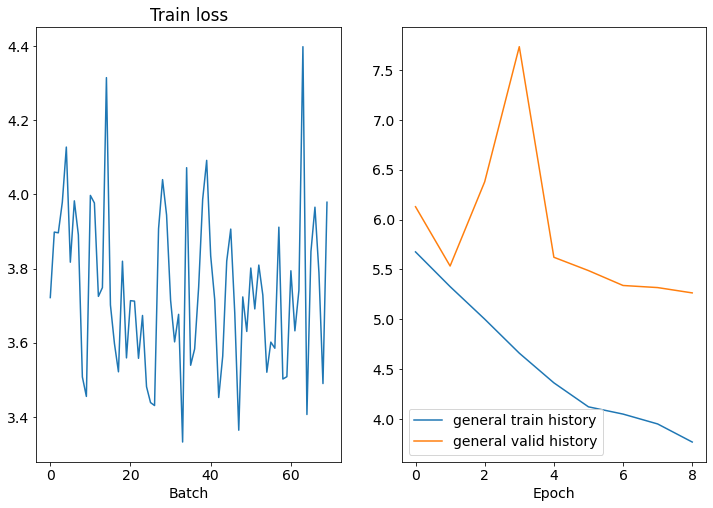

Epoch: 10 | Time: 1m 42s
	Train Loss: 3.740 | Train PPL:  42.116
	 Val. Loss: 5.116 |  Val. PPL: 166.746
CPU times: user 14min 50s, sys: 2min 3s, total: 16min 54s
Wall time: 16min 57s


In [ ]:
%%time
optimizer = optim.Adam(baseline.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

train_iterator, valid_iterator, test_iterator = get_iterators()
train(baseline, "base_line", train_iterator, valid_iterator, optimizer, criterion, n_epochs = 10)

In [ ]:
get_results(baseline, test_iterator, trg_vocab)

The model has 14,851,608 trainable parameters


15it [00:04,  3.26it/s]


BLEU score: 4.993171738426697
Successful examples of translation:

Original: the nature reserve is 4 km away .
Generated: the is is km from the property .

Original: the train station is 1 km away .
Generated: the is is km from the property .

Original: the park is 2 km away .
Generated: the is is km from the property .

Bad translation examples: 

Original: there are several places of interest in the hotel ' s area .
Generated: the , .

Original: free private parking is available on site at the apartments .
Generated: free toiletries .

Original: free private parking is also available at this apartment .
Generated: free toiletries .



In [5]:
import seq_to_seq_with_Attention_LSTM

train_iterator, valid_iterator, test_iterator = get_iterators(batch_size=128)
ss_attent_lstm = seq_to_seq_with_Attention_LSTM.get_model(len(src_vocab), len(trg_vocab))

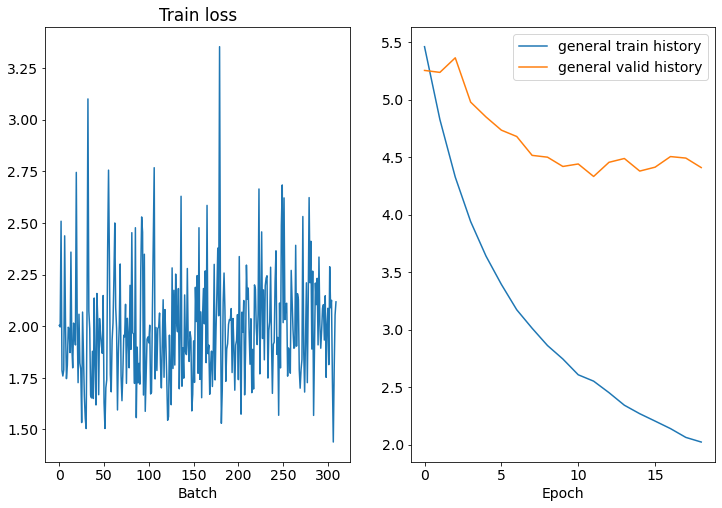

Epoch: 20 | Time: 4m 57s
	Train Loss: 1.987 | Train PPL:   7.292
	 Val. Loss: 4.567 |  Val. PPL:  96.232
CPU times: user 1h 19min 46s, sys: 19min 30s, total: 1h 39min 16s
Wall time: 1h 39min 7s


In [6]:
%%time
optimizer = optim.Adam(ss_attent_lstm.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

train(ss_attent_lstm, "seq_to_seq_Attention_LSTM", train_iterator, 
     valid_iterator, optimizer, criterion, n_epochs = 20)

In [7]:
get_results(ss_attent_lstm, test_iterator, trg_vocab)

The model has 19,127,095 trainable parameters


59it [00:09,  6.55it/s]


BLEU score: 30.26815406269547
Successful examples of translation:

Original: guests benefit from balcony .
Generated: guests benefit from balcony .

Original: wi - fi is free .
Generated: wi - fi is free .

Original: guests can enjoy the on - site bar .
Generated: guests can enjoy the on - site bar .

Bad translation examples: 

Original: towels and bed linen are available in this self - catering accommodation .
Generated: bed linen and towels are provided .

Original: the bathroom in the apartment is fitted with a shower .
Generated: the bathroom comes with a shower .

Original: the 24 - hour reception allows guests during their stay .
Generated: you will find a 24 - hour front desk at the property .



In [8]:
torch.save(ss_attent_lstm.state_dict(), "models/seq_to_seq_Attention_LSTM.pt")